In [625]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.preprocessing import scale
from sklearn import cross_validation

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('darkgrid')

# Lab

### § 6.6.1 Ridge Regression 

In [14]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 41.1+ KB


In [234]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
League_A       263 non-null float64
League_N       263 non-null float64
Division_E     263 non-null float64
Division_W     263 non-null float64
NewLeague_A    263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(6)
memory usage: 14.4 KB


In [293]:
# Drop the column with names and the ones for which we created dummy variables
X_ = df.drop(['Unnamed: 0', 'Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
y = df.Salary
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1 KB


For the __glmnet()__ function in R the penalty is defined as:
### $$ \lambda\bigg(\frac{1}{2}(1−\alpha)|\beta|^2_2 \ +\ \alpha|\beta|_1\bigg) $$
(See R documentation and http://core.ac.uk/download/pdf/6287975.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above penalty to
### $$ \frac{1}{2}\lambda |\beta|^2_2 $$
The sklearn __Ridge()__ function has the standard L2 penalty:
###$$ \lambda |\beta|^2_2 $$

This means that for a given L2 penalty in glmnet(), we need to use half the lambda in Ridge().

In [620]:
regr = Ridge(alpha=(0.5*11498))
regr.fit(X, y)
print(regr.get_params)
print(regr.intercept_)
print(pd.Series(regr.coef_, index=X.columns))

<bound method Ridge.get_params of Ridge(alpha=5749.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)>
104.921324268
AtBat         -1.737541
Hits           5.627359
HmRun          0.007559
Runs          -0.073590
RBI            0.544605
Walks          4.792407
Years         -0.126203
CAtBat        -0.240853
CHits          0.416139
CHmRun         0.144927
CRuns          1.284517
CRBI           0.661134
CWalks        -0.612224
PutOuts        0.294636
Assists        0.343332
Errors        -1.677869
League_N       0.478324
Division_W    -1.257765
NewLeague_N    0.346896
dtype: float64


For some reason I do not get the same results as in R. 

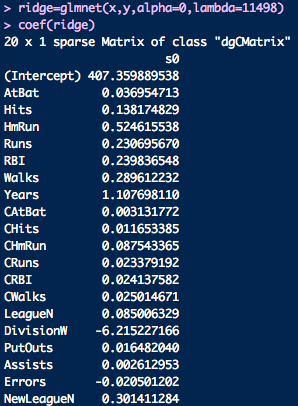

In [627]:
Image('R_glmnet.png')

When adding the argument $normalisation = FALSE$ to the glmnet() call in R, the results are about the same. I wonder why.

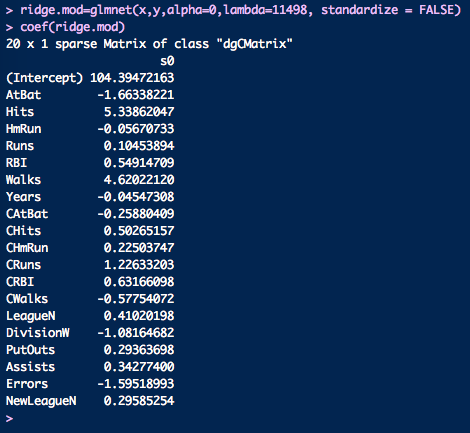

In [629]:
Image('R_glmnet2.png')